In [1]:
#IMPORTS

import sklearn as skl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from scipy.stats import iqr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
#USING CROSS VALIDATION
from sklearn.model_selection import cross_val_score

In [2]:
#carregar os datasets
traffic_train = pd.read_csv("training_data.csv", encoding = 'unicode_escape', engine ='python')
traffic_test = pd.read_csv("test_data.csv", encoding = 'unicode_escape', engine ='python')

#traffic_train = traffic_train.drop_duplicates()
#traffic_test = traffic_test.drop_duplicates()

In [3]:
traffic_train.describe()

,AVERAGE_FREE_FLOW_SPEED,AVERAGE_TIME_DIFF,AVERAGE_FREE_FLOW_TIME,AVERAGE_TEMPERATURE,AVERAGE_ATMOSP_PRESSURE,AVERAGE_HUMIDITY,AVERAGE_WIND_SPEED,AVERAGE_PRECIPITATION
count,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,6812.0
mean,40.661010,25.637111,81.143952,16.193482,1017.388139,80.084190,3.058573,0.0
std,4.119023,33.510507,8.294401,5.163492,5.751061,18.238863,2.138421,0.0
min,30.500000,0.000000,46.400000,0.000000,985.000000,14.000000,0.000000,0.0
25%,37.600000,2.275000,75.400000,13.000000,1015.000000,69.750000,1.000000,0.0
50%,40.700000,12.200000,82.400000,16.000000,1017.000000,83.000000,3.000000,0.0
75%,43.500000,36.200000,87.400000,19.000000,1021.000000,93.000000,4.000000,0.0
max,55.900000,296.500000,112.000000,35.000000,1033.000000,100.000000,14.000000,0.0


In [4]:
#Percebe-se que todos os valores de AVERAGE_PRECIPITATION estão a 0, logo conlui-se que esta coluna é desprezável
#e por isso pode ser removida
traffic_train = traffic_train.drop(['AVERAGE_PRECIPITATION'], axis=1)
traffic_test = traffic_test.drop(['AVERAGE_PRECIPITATION'], axis=1)

In [5]:
traffic_train.info()
#verifica-se que AVERAGE_CLOUDINESS e AVERAGE_RAIN têm alguns valores a nulo, logo será necessário tratar as linhas
#onde tal ocorre

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6812 entries, 0 to 6811
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   city_name                6812 non-null   object 
 1   record_date              6812 non-null   object 
 2   AVERAGE_SPEED_DIFF       6812 non-null   object 
 3   AVERAGE_FREE_FLOW_SPEED  6812 non-null   float64
 4   AVERAGE_TIME_DIFF        6812 non-null   float64
 5   AVERAGE_FREE_FLOW_TIME   6812 non-null   float64
 6   LUMINOSITY               6812 non-null   object 
 7   AVERAGE_TEMPERATURE      6812 non-null   float64
 8   AVERAGE_ATMOSP_PRESSURE  6812 non-null   float64
 9   AVERAGE_HUMIDITY         6812 non-null   float64
 10  AVERAGE_WIND_SPEED       6812 non-null   float64
 11  AVERAGE_CLOUDINESS       4130 non-null   object 
 12  AVERAGE_RAIN             563 non-null    object 
dtypes: float64(7), object(6)
memory usage: 692.0+ KB


In [6]:
traffic_train['AVERAGE_CLOUDINESS'].unique()
#Percebe-se que há valores de AVERAGE_CLOUDINESS que simbolizam a mesma situação, e portanto será melhor agrupar
#esse conjunto de valores

array([nan, 'céu claro', 'nuvens dispersas', 'céu pouco nublado',
       'céu limpo', 'algumas nuvens', 'nuvens quebrados', 'tempo nublado',
       'nuvens quebradas', 'nublado'], dtype=object)

In [7]:
#agrupar valores repetidos no AVERAGE_CLOUDINESS

preencher = []
for ac3 in zip(traffic_train['AVERAGE_CLOUDINESS']):
    ac = ac3[0]
    if ac == 'céu claro' or ac == 'céu limpo':
        preencher.append('céu claro')
    elif ac=='nuvens quebrados' or ac=='nuvens quebradas' or ac == 'nuvens dispersas' or ac=='algumas nuvens' or ac=='céu pouco nublado':
        preencher.append('céu pouco nublado')
    elif ac=='tempo nublado' or ac=='nublado':
        preencher.append('céu nublado')
    else:#quando é nan
        preencher.append(ac)

traffic_train['AVERAGE_CLOUDINESS'] = preencher

preencher = []
for ac3 in zip(traffic_test['AVERAGE_CLOUDINESS']):
    ac = ac3[0]
    if ac == 'céu claro' or ac == 'céu limpo':
        preencher.append('céu claro')
    elif ac=='nuvens quebrados' or ac=='nuvens quebradas' or ac == 'nuvens dispersas' or ac=='algumas nuvens' or ac=='céu pouco nublado':
        preencher.append('céu pouco nublado')
    elif ac=='tempo nublado' or ac=='nublado':
        preencher.append('céu nublado')
    else:#quando é nan
        preencher.append(ac)

traffic_test['AVERAGE_CLOUDINESS'] = preencher

In [8]:
traffic_train['AVERAGE_CLOUDINESS'].unique()

array([nan, 'céu claro', 'céu pouco nublado', 'céu nublado'], dtype=object)

In [9]:
#preencher nulos da AVERAGE_CLOUDINESS com base na AVERAGE_ATMOSP_PRESSURE

preencher = []
for ac, atm in zip(traffic_train['AVERAGE_CLOUDINESS'], traffic_train['AVERAGE_ATMOSP_PRESSURE']):
    if  str(ac) == 'nan':
        if atm > 1025:
            preencher.append('céu claro')
        elif atm > 1005:
            preencher.append('céu pouco nublado')
        else:
            preencher.append('céu nublado')
    else:
        preencher.append(ac)

traffic_train['AVERAGE_CLOUDINESS'] = preencher

preencher = []
for ac, atm in zip(traffic_test['AVERAGE_CLOUDINESS'], traffic_test['AVERAGE_ATMOSP_PRESSURE']):
    if  str(ac) == 'nan':
        if atm > 1025:
            preencher.append('céu claro')
        elif atm > 1005:
            preencher.append('céu pouco nublado')
        else:
            preencher.append('céu nublado')
    else:
        preencher.append(ac)

traffic_test['AVERAGE_CLOUDINESS'] = preencher

#toda AVERAGE_CLOUDINESS preenchida

In [10]:
traffic_train['AVERAGE_RAIN'].unique()
#Percebe-se que há valores de AVERAGE_RAIN que simbolizam a mesma situação, e portanto será melhor agrupar
#esse conjunto de valores

array([nan, 'chuva fraca', 'chuva', 'chuva leve', 'chuvisco fraco',
       'chuva moderada', 'trovoada com chuva leve', 'aguaceiros',
       'aguaceiros fracos', 'chuva de intensidade pesada',
       'trovoada com chuva', 'chuva de intensidade pesado', 'chuva forte',
       'chuvisco e chuva fraca'], dtype=object)

In [11]:
# Agrupar valores repetidos no AVERAGE_RAIN

preencher = []
for ar3 in zip(traffic_train['AVERAGE_RAIN']):
    ar = ar3[0]
    if ar == 'chuva fraca' or ar == 'chuva leve' or ar == 'chuvisco fraco' or ar == 'chuvisco e chuva fraca' or ar == 'trovoada com chuva leve':
        preencher.append('chuva fraca')
    elif ar == 'chuva moderada' or ar == 'chuva' or ar == 'aguaceiros fracos' or ar == 'trovoada com chuva':
        preencher.append('chuva moderada')
    elif ar == 'chuva de intensidade pesada' or ar == 'chuva de intensidade pesado' or ar == 'chuva forte' or ar == 'aguaceiros':
        preencher.append('chuva forte')
    else:#quando é nan
        preencher.append(ar)

traffic_train['AVERAGE_RAIN'] = preencher

preencher = []
for ar3 in zip(traffic_test['AVERAGE_RAIN']):
    ar = ar3[0]
    if ar == 'chuva fraca' or ar == 'chuva leve' or ar == 'chuvisco fraco' or ar == 'chuvisco e chuva fraca' or ar == 'trovoada com chuva leve':
        preencher.append('chuva fraca')
    elif ar == 'chuva moderada' or ar == 'chuva' or ar == 'aguaceiros fracos' or ar == 'trovoada com chuva':
        preencher.append('chuva moderada')
    elif ar == 'chuva de intensidade pesada' or ar == 'chuva de intensidade pesado' or ar == 'chuva forte' or ar == 'aguaceiros':
        preencher.append('chuva forte')
    else:#quando é nan
        preencher.append(ar)

traffic_test['AVERAGE_RAIN'] = preencher

In [12]:
traffic_train['AVERAGE_RAIN'].unique()

array([nan, 'chuva fraca', 'chuva moderada', 'chuva forte'], dtype=object)

In [13]:
#preencher valores nulos na AVERAGE_RAIN com base na AVERAGE_CLOUDINESS e AVERAGE_HUMIDITY

preencher = []
for ac, ah, ar in zip(traffic_train['AVERAGE_CLOUDINESS'], traffic_train['AVERAGE_HUMIDITY'], traffic_train['AVERAGE_RAIN']):
    if  str(ar) == 'nan':
        if str(ac) == 'céu nublado':
            if ah > 70:
                preencher.append('chuva forte')
            elif ah > 50:
                preencher.append('chuva moderada')
            elif ah > 30:
                preencher.append('chuva fraca')
            else:
                preencher.append('sem chuva')
        elif str(ac) == 'céu pouco nublado':
            if ah > 70:
                preencher.append('chuva moderada')
            elif ah > 50:
                preencher.append('chuva fraca')
            else:
                preencher.append('sem chuva')
        else:
            preencher.append('sem chuva')
    else:
        preencher.append(ar)

traffic_train['AVERAGE_RAIN'] = preencher

preencher = []
for ac, ah, ar in zip(traffic_test['AVERAGE_CLOUDINESS'], traffic_test['AVERAGE_HUMIDITY'], traffic_test['AVERAGE_RAIN']):
    if  str(ar) == 'nan':
        if str(ac) == 'céu nublado':
            if ah > 70:
                preencher.append('chuva forte')
            elif ah > 50:
                preencher.append('chuva moderada')
            elif ah > 30:
                preencher.append('chuva fraca')
            else:
                preencher.append('sem chuva')
        elif str(ac) == 'céu pouco nublado':
            if ah > 70:
                preencher.append('chuva moderada')
            elif ah > 50:
                preencher.append('chuva fraca')
            else:
                preencher.append('sem chuva')
        else:
            preencher.append('sem chuva')
    else:
        preencher.append(ar)

traffic_test['AVERAGE_RAIN'] = preencher

#toda a RAIN preenchida

In [14]:
#quando céu é claro, então não pode estar a chover

preencher = []
for ac, ar in zip(traffic_train['AVERAGE_CLOUDINESS'], traffic_train['AVERAGE_RAIN']):
    if str(ac) == 'céu claro':
        preencher.append('sem chuva')
    else:
        preencher.append(ar)

traffic_train['AVERAGE_RAIN'] = preencher

preencher = []
for ac, ar in zip(traffic_test['AVERAGE_CLOUDINESS'], traffic_test['AVERAGE_RAIN']):
    if str(ac) == 'céu claro':
        preencher.append('sem chuva')
    else:
        preencher.append(ar)

traffic_test['AVERAGE_RAIN'] = preencher

In [15]:
#Através da coluna record_date é possível saber o dia da semana

#obter coluna com o dia da semana
def diaSemana(data):
    from datetime import datetime, date
    data = datetime.strptime(data, '%Y-%m-%d %H:%M:%S').date()
    return data.weekday()

traffic_train['DiaSemana'] = traffic_train['record_date'].apply(diaSemana)
traffic_test['DiaSemana'] = traffic_test['record_date'].apply(diaSemana)

In [16]:
#Verificar se é fim de semana ou não

def fim_de_semana(dia):
    if dia >= 5:
        return 'Sim'
    return 'Não'

traffic_train['FimDeSemana'] = traffic_train['DiaSemana'].apply(fim_de_semana)
traffic_test['FimDeSemana'] = traffic_test['DiaSemana'].apply(fim_de_semana)

In [17]:
#Através da coluna record_date é possível saber o dia do mês

#obter coluna com o dia do mês
def dia(data):
    from datetime import datetime, date
    data = datetime.strptime(data, '%Y-%m-%d %H:%M:%S').date()
    return data.day

traffic_train['Dia'] = traffic_train['record_date'].apply(dia)
traffic_test['Dia'] = traffic_test['record_date'].apply(dia)

In [18]:
#Através da coluna record_date é possível saber o mês

#obter coluna com o mês
def mes(data):
    from datetime import datetime, date
    data = datetime.strptime(data, '%Y-%m-%d %H:%M:%S').date()
    return data.month

traffic_train['Mes'] = traffic_train['record_date'].apply(mes)
traffic_test['Mes'] = traffic_test['record_date'].apply(mes)

In [19]:
#Como o dataset se baseia nas ruas da cidade do Porto, é possível verificar se um
#dado dia simboliza um Feriado no Porto(obtidos na internet)

f1 = (1,1)
f2 = (25,4)
f3 = (1,5)
f4 = (12,5)
f5 = (13,5)
f6 = (10,6)
f7 = (24,6)
f8 = (15,8)
f9 = (5,10)
f10 = (1,11)
f11 = (1,12)
f12 = (8,12)
f13 = (25,12)

feriados = [f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13]

#obter coluna com informação do Feriado
preencher = []
for d, m in zip(traffic_train['Dia'], traffic_train['Mes']):
    date = (d,m)
    if date in feriados:
        preencher.append('Sim')
    else:
        preencher.append('Não')

traffic_train['Feriado'] = preencher
        
preencher = []
for d, m in zip(traffic_test['Dia'], traffic_test['Mes']):
    date = (d,m)
    if date in feriados:
        preencher.append('Sim')
    else:
        preencher.append('Não')

traffic_test['Feriado'] = preencher


In [20]:
#Através da coluna Mes é possível saber qual a Estação do Ano

#obter coluna com o estação do ano
preencher = []
for d, m in zip(traffic_train['Dia'], traffic_train['Mes']):
    if m <= 3:
        if d <= 19:
            preencher.append('inverno')
        else:
            preencher.append('primavera')
    else:
        if m <= 6:
            if d <= 20:
                preencher.append('primavera')
            else:
                preencher.append('verão')
        else:
            if m <= 9:
                if d <= 21:
                    preencher.append('verão')
                else:
                    preencher.append('outono')
            else:
                if m <= 12:
                    if d <= 20:
                        preencher.append('outono')
                    else:
                        preencher.append('inverno')

traffic_train['Estacao'] = preencher

preencher = []
for d, m in zip(traffic_test['Dia'], traffic_test['Mes']):
    if m <= 3:
        if d <= 19:
            preencher.append('inverno')
        else:
            preencher.append('primavera')
    else:
        if m <= 6:
            if d <= 20:
                preencher.append('primavera')
            else:
                preencher.append('verão')
        else:
            if m <= 9:
                if d <= 21:
                    preencher.append('verão')
                else:
                    preencher.append('outono')
            else:
                if m <= 12:
                    if d <= 20:
                        preencher.append('outono')
                    else:
                        preencher.append('inverno')

traffic_test['Estacao'] = preencher                                          

In [21]:
#Através da coluna record_date é possível a hora do dia

#obter coluna com a hora do dia
def Hour(data):
    from datetime import datetime,time
    hora = datetime.strptime(data,'%Y-%m-%d %H:%M:%S').time()
    return hora.hour

traffic_train['Hora'] = traffic_train['record_date'].apply(Hour)
traffic_test['Hora']= traffic_test['record_date'].apply(Hour)

In [22]:
#Através da coluna Hora é que parte do dia essa hora se enquadra

#obter coluna com parte do dia
def daypart(hour):
    if hour > 0 and hour <= 7:
        return 'Madrugada'
    elif hour >= 8 and hour <= 19:
        return 'Hora de Trabalho'
    else:
        return 'Noite'

traffic_train['Parte_do_Dia'] = traffic_train['Hora'].apply(daypart)
traffic_test['Parte_do_Dia'] = traffic_test['Hora'].apply(daypart)

<AxesSubplot:>

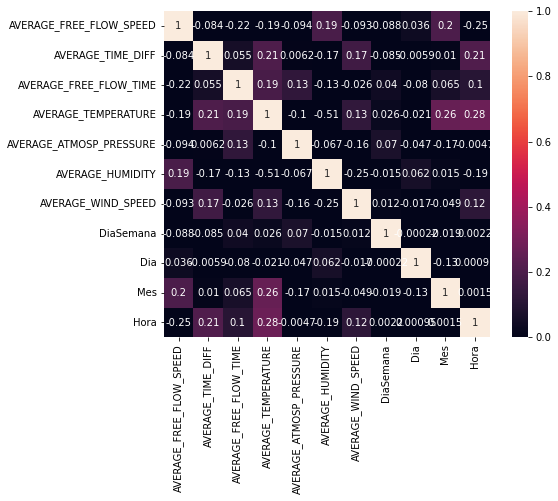

In [23]:
corr_matrix= traffic_train.corr()
f, ax =plt.subplots(figsize=(8,6))
sns.heatmap(corr_matrix,vmin=0,vmax=1,square=True,annot=True)

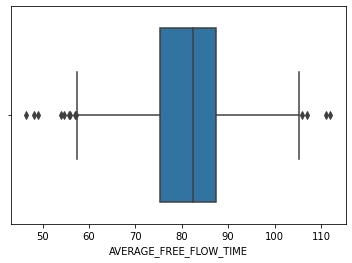

In [24]:
ax = sns.boxplot(x=traffic_train['AVERAGE_FREE_FLOW_TIME'])

In [24]:
#tratar outliers AVERAGE_FREE_FLOW_SPEED
qff1 = 30
qff2 = 50

#remover outliers compensa
traffic_train = traffic_train[(traffic_train['AVERAGE_FREE_FLOW_SPEED'] < qff2) & (traffic_train['AVERAGE_FREE_FLOW_SPEED'] > qff1)]
traffic_test = traffic_test[(traffic_test['AVERAGE_FREE_FLOW_SPEED'] < qff2) & (traffic_test['AVERAGE_FREE_FLOW_SPEED'] > qff1)]

In [25]:
#tratar outliers AVERAGE_FREE_FLOW_TIME
qff1 = 60
qff2 = 105

preencher = []
for afft3 in zip(traffic_train['AVERAGE_FREE_FLOW_TIME']):
    afft = afft3[0]
    if afft > qff2:
        preencher.append(qff2)
    elif afft < qff1:
        preencher.append(qff1)
    else:
        preencher.append(afft)

traffic_train['AVERAGE_FREE_FLOW_TIME'] = preencher

preencher = []
for afft3 in zip(traffic_test['AVERAGE_FREE_FLOW_TIME']):
    afft = afft3[0]
    if afft > qff2:
        preencher.append(qff2)
    elif afft < qff1:
        preencher.append(qff1)
    else:
        preencher.append(afft)

traffic_test['AVERAGE_FREE_FLOW_TIME'] = preencher

In [26]:
#tratar outliers AVERAGE_TIME_DIFF
q1 = traffic_train['AVERAGE_TIME_DIFF'].quantile(0.9)#melhor valor

preencher = []
for atf3 in zip(traffic_train['AVERAGE_TIME_DIFF']):
    atf = atf3[0]
    if atf > q1:
        preencher.append(q1)
    else:
        preencher.append(atf)

traffic_train['AVERAGE_TIME_DIFF'] = preencher

preencher = []
for atf3 in zip(traffic_test['AVERAGE_TIME_DIFF']):
    atf = atf3[0]
    if atf > q1:
        preencher.append(q1)
    else:
        preencher.append(atf)

traffic_test['AVERAGE_TIME_DIFF'] = preencher

In [27]:
#tratar outliers AVERAGE_TEMPERATURE
qt1 = 5
qt2 = 30

preencher = []
for at3 in zip(traffic_train['AVERAGE_TEMPERATURE']):
    at = at3[0]
    if at > qt2:
        preencher.append(qt2)
    elif at < qt1:
        preencher.append(qt1)
    else:
        preencher.append(at)

traffic_train['AVERAGE_TEMPERATURE'] = preencher

preencher = []
for at3 in zip(traffic_test['AVERAGE_TEMPERATURE']):
    at = at3[0]
    if at > qt2:
        preencher.append(qt2)
    elif at < qt1:
        preencher.append(qt1)
    else:
        preencher.append(at)

traffic_test['AVERAGE_TEMPERATURE'] = preencher

In [28]:
#tratar outliers AVERAGE_WIND_SPEED
qw = 10#melhor valor

traffic_train = traffic_train[(traffic_train['AVERAGE_WIND_SPEED'] < qw)]
traffic_test = traffic_test[(traffic_test['AVERAGE_WIND_SPEED'] < qw)]

In [29]:
traffic_train.head()

,city_name,record_date,AVERAGE_SPEED_DIFF,AVERAGE_FREE_FLOW_SPEED,AVERAGE_TIME_DIFF,AVERAGE_FREE_FLOW_TIME,LUMINOSITY,AVERAGE_TEMPERATURE,AVERAGE_ATMOSP_PRESSURE,AVERAGE_HUMIDITY,...,AVERAGE_CLOUDINESS,AVERAGE_RAIN,DiaSemana,FimDeSemana,Dia,Mes,Feriado,Estacao,Hora,Parte_do_Dia
0,Porto,2019-08-29 07:00:00,Medium,41.5,11.5,71.4,LIGHT,15.0,1019.0,100.0,...,céu pouco nublado,chuva moderada,3,Não,29,8,Não,outono,7,Madrugada
1,Porto,2018-08-10 14:00:00,High,41.7,48.3,87.4,LIGHT,21.0,1021.0,53.0,...,céu claro,sem chuva,4,Não,10,8,Não,verão,14,Hora de Trabalho
2,Porto,2019-09-01 16:00:00,High,38.6,38.4,85.2,LIGHT,26.0,1014.0,61.0,...,céu pouco nublado,chuva fraca,6,Sim,1,9,Não,verão,16,Hora de Trabalho
3,Porto,2019-02-26 11:00:00,High,37.4,61.0,94.1,LIGHT,18.0,1025.0,48.0,...,céu claro,sem chuva,1,Não,26,2,Não,primavera,11,Hora de Trabalho
6,Porto,2018-10-03 21:00:00,None,45.7,4.0,79.8,DARK,16.0,1020.0,58.0,...,céu claro,sem chuva,2,Não,3,10,Não,outono,21,Noite


In [30]:
traffic_train['AVERAGE_SPEED_DIFF']=traffic_train['AVERAGE_SPEED_DIFF'].astype('category')
d = dict(enumerate(traffic_train['AVERAGE_SPEED_DIFF'].cat.categories))
traffic_train['AVERAGE_SPEED_DIFF']=traffic_train['AVERAGE_SPEED_DIFF'].cat.codes

traffic_train['AVERAGE_CLOUDINESS']=traffic_train['AVERAGE_CLOUDINESS'].astype('category')
traffic_train['AVERAGE_CLOUDINESS']=traffic_train['AVERAGE_CLOUDINESS'].cat.codes

traffic_train['LUMINOSITY']=traffic_train['LUMINOSITY'].astype('category')
traffic_train['LUMINOSITY']=traffic_train['LUMINOSITY'].cat.codes

traffic_train['AVERAGE_RAIN']=traffic_train['AVERAGE_RAIN'].astype('category')
traffic_train['AVERAGE_RAIN']=traffic_train['AVERAGE_RAIN'].cat.codes

traffic_train['DiaSemana']=traffic_train['DiaSemana'].astype('category')
traffic_train['DiaSemana']=traffic_train['DiaSemana'].cat.codes

traffic_train['Dia']=traffic_train['Dia'].astype('category')
traffic_train['Dia']=traffic_train['Dia'].cat.codes

traffic_train['Mes']=traffic_train['Mes'].astype('category')
traffic_train['Mes']=traffic_train['Mes'].cat.codes

traffic_train['Estacao']=traffic_train['Estacao'].astype('category')
traffic_train['Estacao']=traffic_train['Estacao'].cat.codes

traffic_train['Feriado']=traffic_train['Feriado'].astype('category')
traffic_train['Feriado']=traffic_train['Feriado'].cat.codes

traffic_train['Hora']=traffic_train['Hora'].astype('category')
traffic_train['Hora']=traffic_train['Hora'].cat.codes

traffic_train['Parte_do_Dia']=traffic_train['Parte_do_Dia'].astype('category')
traffic_train['Parte_do_Dia']=traffic_train['Parte_do_Dia'].cat.codes

traffic_train['FimDeSemana']=traffic_train['FimDeSemana'].astype('category')
traffic_train['FimDeSemana']=traffic_train['FimDeSemana'].cat.codes

#x_train = traffic_train.drop(['AVERAGE_SPEED_DIFF','city_name', 'record_date'],axis=1)
#y_train = traffic_train['AVERAGE_SPEED_DIFF'].to_frame()

#x_train.describe()
#x_train.head()

In [31]:
traffic_test['AVERAGE_CLOUDINESS']=traffic_test['AVERAGE_CLOUDINESS'].astype('category')
traffic_test['AVERAGE_CLOUDINESS']=traffic_test['AVERAGE_CLOUDINESS'].cat.codes

traffic_test['LUMINOSITY']=traffic_test['LUMINOSITY'].astype('category')
traffic_test['LUMINOSITY']=traffic_test['LUMINOSITY'].cat.codes

traffic_test['AVERAGE_RAIN']=traffic_test['AVERAGE_RAIN'].astype('category')
traffic_test['AVERAGE_RAIN']=traffic_test['AVERAGE_RAIN'].cat.codes

traffic_test['DiaSemana']=traffic_test['DiaSemana'].astype('category')
traffic_test['DiaSemana']=traffic_test['DiaSemana'].cat.codes

traffic_test['Dia']=traffic_test['Dia'].astype('category')
traffic_test['Dia']=traffic_test['Dia'].cat.codes

traffic_test['Mes']=traffic_test['Mes'].astype('category')
traffic_test['Mes']=traffic_test['Mes'].cat.codes

traffic_test['Estacao']=traffic_test['Estacao'].astype('category')
traffic_test['Estacao']=traffic_test['Estacao'].cat.codes

traffic_test['Feriado']=traffic_test['Feriado'].astype('category')
traffic_test['Feriado']=traffic_test['Feriado'].cat.codes

traffic_test['Hora']=traffic_test['Hora'].astype('category')
traffic_test['Hora']=traffic_test['Hora'].cat.codes

traffic_test['Parte_do_Dia']=traffic_test['Parte_do_Dia'].astype('category')
traffic_test['Parte_do_Dia']=traffic_test['Parte_do_Dia'].cat.codes

traffic_test['FimDeSemana']=traffic_test['FimDeSemana'].astype('category')
traffic_test['FimDeSemana']=traffic_test['FimDeSemana'].cat.codes

#x_test=traffic_test.drop(['city_name', 'record_date'],axis=1)

In [32]:
X = traffic_train.drop(['AVERAGE_SPEED_DIFF','city_name', 'record_date'],axis=1)
y = traffic_train['AVERAGE_SPEED_DIFF'].to_frame()

X_test = traffic_test.drop(['city_name', 'record_date'],axis=1)
#y_test = traffic_test['AVERAGE_SPEED_DIFF'].to_frame()

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2021)
X_train.head()

,AVERAGE_FREE_FLOW_SPEED,AVERAGE_TIME_DIFF,AVERAGE_FREE_FLOW_TIME,LUMINOSITY,AVERAGE_TEMPERATURE,AVERAGE_ATMOSP_PRESSURE,AVERAGE_HUMIDITY,AVERAGE_WIND_SPEED,AVERAGE_CLOUDINESS,AVERAGE_RAIN,DiaSemana,FimDeSemana,Dia,Mes,Feriado,Estacao,Hora,Parte_do_Dia
3869,45.2,72.5,87.5,1,20.0,1021.0,72.0,7.0,2,2,1,0,12,7,0,3,18,0
4923,36.9,0.0,92.4,0,16.0,1014.0,100.0,7.0,2,2,4,0,18,6,0,3,5,1
231,43.9,6.1,81.1,0,13.0,1021.0,93.0,0.0,2,2,5,1,2,10,0,1,20,2
6199,40.5,67.3,87.8,1,25.0,1018.0,33.0,3.0,0,3,3,0,3,9,0,1,14,0
4272,42.6,0.0,72.3,0,15.0,1013.0,72.0,3.0,2,2,0,0,16,5,0,2,23,2


In [34]:
#corr_matrix= x.corr()
#f, ax =plt.subplots(figsize=(8,6))
#sns.heatmap(corr_matrix,vmin=0,vmax=1,square=True,annot=True)

In [35]:
numerical = X_train.select_dtypes('number').columns
categorical = X_train.select_dtypes('category').columns

In [36]:
#X_train.head()

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

ohe= OneHotEncoder()
s= StandardScaler()
ct1= make_column_transformer((ohe,categorical),(s,numerical))
#ct1= make_column_transformer((ohe,categorical),remainder='passthrough')

lr = LogisticRegression(solver='liblinear')#0.7231
svm = SVC(gamma='scale') #0.7858
knn = KNeighborsClassifier()
ada = AdaBoostClassifier(random_state=0)#0.7422
gb = GradientBoostingClassifier(random_state=0)#0.8163
rf = RandomForestClassifier(random_state=0)#0.7945
et=  ExtraTreesClassifier(random_state=0)#0.7647

models = [lr,svm,knn,ada,gb,rf,et]
acc = 0

for model in models: 
    pipe = make_pipeline(ct1, model)
    pipe.fit(X_train, np.ravel(y_train))
    y_pred = pipe.predict(X_test)
    #if model == gb:
    #    i=1
    #    f=open('output_almost.csv','w')
    #    f.write('RowId,Speed_Diff\n')
    #    for p in y_pred:
    #        f.write(f'{i},{d[p]}\n')
    #        i += 1
    #    f.close()
    print (f'model : {model} and  accuracy score is : {round(accuracy_score(y_test, y_pred),4)}')
    acc += round(accuracy_score(y_test, y_pred),4)
    
print(f'Average: {acc/7}')
#Logistic Regression(0,7314)
#model = LogisticRegression(solver='liblinear')
#model.fit(X_train, np.ravel(y_train))
#y_pred = model.predict(X_test)
#print("Logistic Regression Accuraccy: ", round(accuracy_score(y_test, y_pred),4))

#Linear Discriminant Analysis(0,6913)
#model = LinearDiscriminantAnalysis()
#model.fit(X_train, np.ravel(y_train))
#y_pred = model.predict(X_test)
#print("Linear Discriminant Analysis Accuraccy: ", round(accuracy_score(y_test, y_pred),4))

#SVC Model(0,5709)
#model = SVC(gamma='scale')
#model.fit(X_train, np.ravel(y_train))
#y_pred = model.predict(X_test)
#print("SVC Model Accuraccy: ", round(accuracy_score(y_test, y_pred),4))


#10-Fold Cross --> bosta
#model = SVC(random_state=2021, gamma='scale')
#scores = cross_val_score(model, x_train, np.ravel(y_train), cv=10)
#print(scores.mean())

model : LogisticRegression(solver='liblinear') and  accuracy score is : 0.7117
model : SVC() and  accuracy score is : 0.7598
model : KNeighborsClassifier() and  accuracy score is : 0.6401
model : AdaBoostClassifier(random_state=0) and  accuracy score is : 0.6056
model : GradientBoostingClassifier(random_state=0) and  accuracy score is : 0.8103
model : RandomForestClassifier(random_state=0) and  accuracy score is : 0.7983
model : ExtraTreesClassifier(random_state=0) and  accuracy score is : 0.8013
Average: 0.7324428571428572


In [33]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler

RANDOM_SEED = 2021

print('TensorFlow version: ',tf.__version__)

TensorFlow version:  2.7.0


In [34]:
scaler_x = MinMaxScaler(feature_range=(0,1)).fit(X)
scaler_x_test = MinMaxScaler(feature_range=(0,1)).fit(X_test)
#scaler_y = MinMaxScaler(feature_range=(0,1)).fit(y)
x_scaled = pd.DataFrame(scaler_x.transform(X[X.columns]), columns=X.columns)
x_test_scaled = pd.DataFrame(scaler_x_test.transform(X_test[X_test.columns]), columns=X_test.columns)
#y_scaled = pd.DataFrame(scaler_y.transform(y[y.columns]), columns=y.columns)

#x_scaled.head()
x_scaled.head()

,AVERAGE_FREE_FLOW_SPEED,AVERAGE_TIME_DIFF,AVERAGE_FREE_FLOW_TIME,LUMINOSITY,AVERAGE_TEMPERATURE,AVERAGE_ATMOSP_PRESSURE,AVERAGE_HUMIDITY,AVERAGE_WIND_SPEED,AVERAGE_CLOUDINESS,AVERAGE_RAIN,DiaSemana,FimDeSemana,Dia,Mes,Feriado,Estacao,Hora,Parte_do_Dia
0,0.567010,0.158621,0.325714,0.5,0.40,0.708333,1.000000,0.333333,1.0,0.666667,0.500000,0.0,0.933333,0.636364,0.0,0.333333,0.304348,0.5
1,0.577320,0.666207,0.782857,0.5,0.64,0.750000,0.453488,0.555556,0.0,1.000000,0.666667,0.0,0.300000,0.636364,0.0,1.000000,0.608696,0.0
2,0.417526,0.529655,0.720000,0.5,0.84,0.604167,0.546512,0.444444,1.0,0.333333,1.000000,1.0,0.000000,0.727273,0.0,1.000000,0.695652,0.0
3,0.355670,0.841379,0.974286,0.5,0.52,0.833333,0.395349,0.444444,0.0,1.000000,0.166667,0.0,0.833333,0.090909,0.0,0.666667,0.478261,0.0
4,0.783505,0.055172,0.565714,0.0,0.44,0.729167,0.511628,0.000000,0.0,1.000000,0.333333,0.0,0.066667,0.818182,0.0,0.333333,0.913043,1.0


In [35]:
def build_model(activation='relu', learning_rate=0.001):
    model=Sequential()
    model.add(Flatten(input_shape=(18,)))
    model.add(Dense(10, activation=activation))
    #model.add(Dense(16,activation=activation))
    model.add(Dense(5, activation='softmax'))
    
    model.compile(
        loss = 'sparse_categorical_crossentropy',
        optimizer = tf.optimizers.Adam(learning_rate),
        metrics = ['accuracy'])
    return model

model = build_model()

In [36]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=RANDOM_SEED)

In [37]:
TUNING_DICT = {
    'activation' : ['relu', 'sigmoid'],
    'learning_rate' : [0.01,0.001]
}

In [38]:
kf = KFold(n_splits=5,shuffle=True, random_state=RANDOM_SEED)

model = KerasClassifier(build_fn=build_model, epochs=100, batch_size=32)
grid_search = GridSearchCV(estimator = model,
                          param_grid=TUNING_DICT,
                          cv = kf,
                          scoring = 'accuracy',
                          refit = 'True',
                          verbose = 1)

grid_search.fit(x_scaled,y, validation_split=0.1, verbose=1)

C:\Users\CARLOS~1\AppData\Local\Temp/ipykernel_14384/1511571238.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  model = KerasClassifier(build_fn=build_model, epochs=100, batch_size=32)


Fitting 5 folds for each of 2 candidates, totalling 10 fits
Epoch 1/100
150/150 [==============================] - 1s 2ms/step - loss: 1.1152 - accuracy: 0.5253 - val_loss: 0.8638 - val_accuracy: 0.6435
Epoch 2/100
150/150 [==============================] - 0s 2ms/step - loss: 0.7846 - accuracy: 0.6680 - val_loss: 0.7238 - val_accuracy: 0.6811
Epoch 3/100
150/150 [==============================] - 0s 2ms/step - loss: 0.6706 - accuracy: 0.7116 - val_loss: 0.6653 - val_accuracy: 0.7017
Epoch 4/100
150/150 [==============================] - 0s 1ms/step - loss: 0.6112 - accuracy: 0.7404 - val_loss: 0.6328 - val_accuracy: 0.7261
Epoch 5/100
150/150 [==============================] - 0s 2ms/step - loss: 0.5786 - accuracy: 0.7545 - val_loss: 0.5864 - val_accuracy: 0.7523
Epoch 6/100
150/150 [==============================] - 0s 1ms/step - loss: 0.5524 - accuracy: 0.7685 - val_loss: 0.5456 - val_accuracy: 0.7880
Epoch 7/100
150/150 [==============================] - 0s 1ms/step - loss: 0.5400 

GridSearchCV(cv=KFold(n_splits=5, random_state=2021, shuffle=True),
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x00000160F06EA970>,
             param_grid={'activation': ['relu'],
                         'learning_rate': [0.01, 0.001]},
             refit='True', scoring='accuracy', verbose=1)

In [39]:
print('Best: %f using %s' % (grid_search.best_score_,grid_search.best_params_))
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params=grid_search.cv_results_['params']
for mean, stdev, param in zip(means,stds,params):
    print("%f (%f) with %r" % (mean,stdev, param))

Best: 0.785285 using {'activation': 'relu', 'learning_rate': 0.001}
0.783333 (0.010708) with {'activation': 'relu', 'learning_rate': 0.01}
0.785285 (0.013371) with {'activation': 'relu', 'learning_rate': 0.001}


In [ ]:
#apartir daqui não interessa?

In [ ]:
param_grid={'C':[1.3,1.4,1.5,1.6,1.7], 'gamma':[0.00015, 0.0002,0.0003, 0.0004, 0.0005],'kernel': ['rbf']}

from sklearn.model_selection import GridSearchCV

grid= GridSearchCV(SVC(random_state=2021),param_grid,refit=True,verbose=3)

grid.fit(x_train,np.ravel(y_train))

print(grid.best_params_)

print(grid.best_estimator_)

#plot_confusion_matrix(grid, x_test, y_test)

grid_predictions = grid.predict(x_test)
#print(classification_report(y_test,grid_predictions))
print(grid_predictions)

In [ ]:
param_grid={'C':[1.45,1.5,1.55,1.6], 'gamma':[0.0005,0.0006,0.0007,0.0008],'kernel': ['rbf']}

from sklearn.model_selection import GridSearchCV

grid= GridSearchCV(SVC(random_state=2021),param_grid,refit=True,verbose=3)

grid.fit(x_train,np.ravel(y_train))

print(grid.best_params_)

print(grid.best_estimator_)

#plot_confusion_matrix(grid, x_test, y_test)

grid_predictions = grid.predict(x_test)
#print(classification_report(y_test,grid_predictions))
print(grid_predictions)

In [36]:
i=1
f=open('output2.csv','w')
f.write('RowId,Speed_Diff\n')
for p in grid_predictions:
    f.write(f'{i},{d[p]}\n')
    i += 1

f.close()